In [2]:
# Import and creating some helper functions
import copy

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def occlude(array):
    """
    Adds occlusion to an image.
    """
    new_array = copy.deepcopy(array)

    for k in range(len(new_array)):
        x = np.random.randint(0, 25)
        new_array[k, x: x + 2, :] = 1.0
    
    return new_array


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


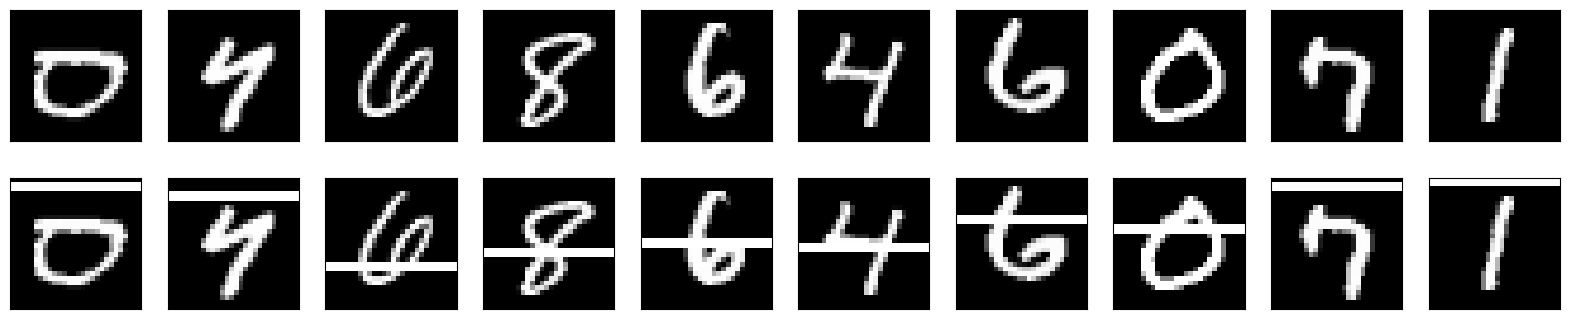

In [4]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = occlude(train_data)
noisy_test_data = occlude(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [7]:
# Our input shape is 28 x 28 x 1
input = layers.Input(shape=(28, 28, 1))

# The Encoder Model
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# The Decoder Model
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder - Note it is the entire concatenation of the encoder and decoder
autoencoder = Model(input, x)

autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - loss: 0.2455 - val_loss: 0.0727
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - loss: 0.0721 - val_loss: 0.0693
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - loss: 0.0695 - val_loss: 0.0678
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - loss: 0.0681 - val_loss: 0.0670
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - loss: 0.0672 - val_loss: 0.0665
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.0667 - val_loss: 0.0659
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - loss: 0.0663 - val_loss: 0.0655
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.0660 - val_loss: 0.0652
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - loss: 0.0656 - val_loss: 0.0649
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - loss: 0.0653 - val_loss: 0.0647
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.0650 - val_loss: 0.0646
Epoch 12/50
469/469 ━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [ ]:
# Extracting the encoder part of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)
encoder.summary()

In [8]:
# Use the encoder to generate latent space representations
latent_train = encoder.predict(train_data)
latent_test = encoder.predict(test_data)
print(latent_test.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(10000, 7, 7, 32)


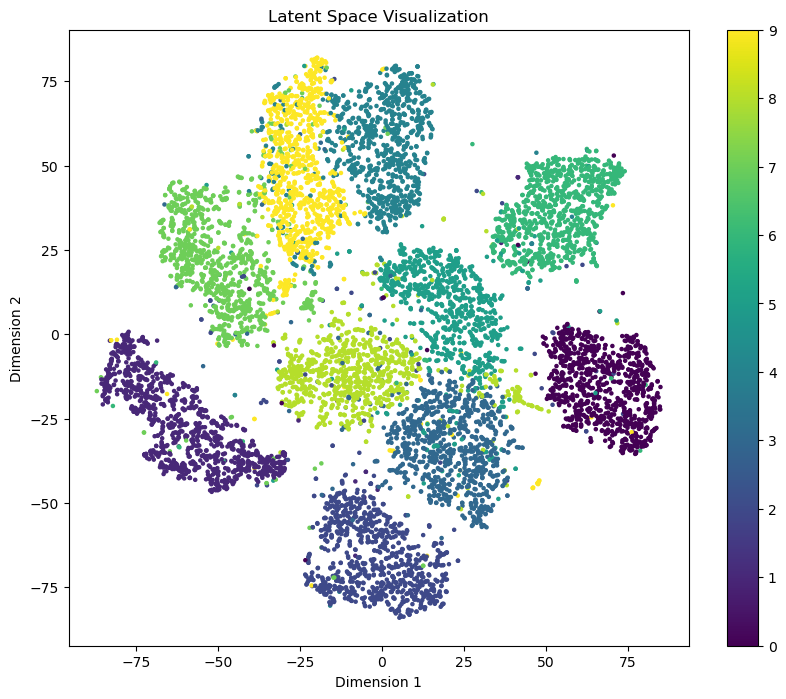

In [9]:
from sklearn.manifold import TSNE

# Reduce the dimensionality of the latent space to 2D using t-SNE
latent_2d = TSNE(n_components=2, random_state=42).fit_transform(latent_test.reshape(len(latent_test), -1))
#colors = np.random.rand(latent_2d.shape[0])
# Plot the 2D latent space
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1],  c=test_labels,cmap='viridis',  s=5)
plt.colorbar()
plt.title("Latent Space Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [12]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.1135 - val_loss: 0.0936
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.0939 - val_loss: 0.0914
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0919 - val_loss: 0.0902
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - loss: 0.0909 - val_loss: 0.0895
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.0879 - val_loss: 0.0870
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.0874 - val_loss: 0.0868
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.0873 - val_loss: 0.0867
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.0858 - val_loss: 0.0854
Epoch 24/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.0859 - val_loss: 0.0854
Epoch 25/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.0857 - val_loss: 0.0853
Epoch 26/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.0856 - val_loss: 0.0852
Epoch 27/50
469/469 ━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


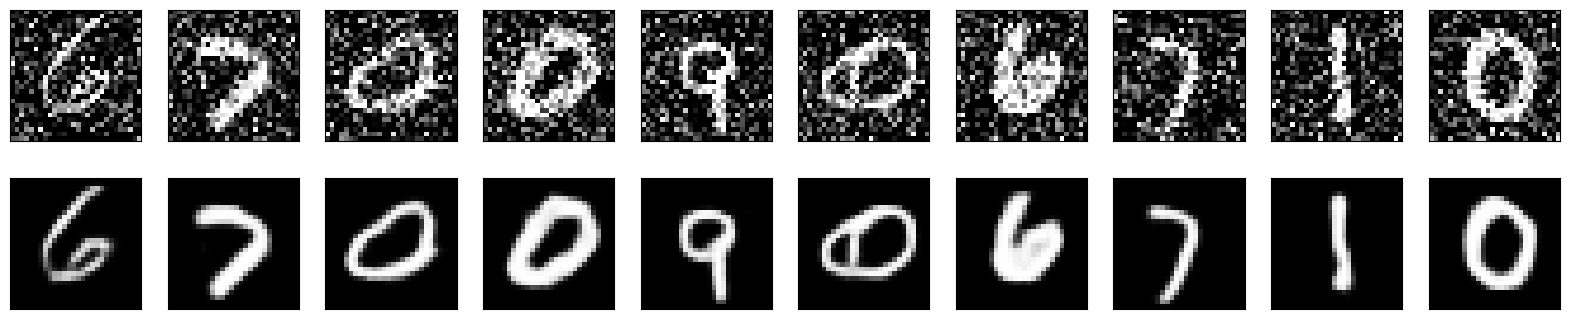

In [13]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)